# 1. Importation des données et des librairies

In [1]:
# Auteur : Mohamed MERAH
# Date: Février 2024
# OpenClassrooms 2023-2024

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.image import imread
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn import cluster, metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

import os
import numpy as np

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
from PIL import Image
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
import time
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

C:\Users\misso\AppData\Local\Temp\ipykernel_50272\248354555.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# **2. Classification supervisée via les données images**

In [2]:
data = pd.read_csv('C:/Users/misso/Desktop/Formation_DS_23_24_MERAH/2-Projet/6- Projet 6/Code/data_categories_image.csv')
data.drop(columns=['Unnamed: 0'], inplace=True)
print(data.shape)
data.head()

(1050, 4)


,uniq_id,image_path,label_name,label
0,55b85ea15a1536d46b7190ad6fff8ce7,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4


# 2.1 Identifié la ou les cibles:

In [3]:
# Check the distribution of the categories in 'label_name'
category_distribution = data['label_name'].value_counts()
category_distribution

label_name
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

# 2.2 Création de X

In [4]:
# Augmenter la limite par défaut (ici, par exemple, fixée à une valeur très élevée)
Image.MAX_IMAGE_PIXELS = None 

def image_prep_fct(data):
    # Définir le chemin d'accès relatif aux image
    base_image_path = 'C:/Users/misso/Desktop/Formation_DS_23_24_MERAH/2-Projet/6- Projet 6/Ressources/Images/'

    prepared_images = []
    for image_name in data['image_path']:
        # Construire le chemin complet de l'image
        image_path = os.path.join(base_image_path, image_name)
        
        # Charger, traiter et prétraiter l'image
        img = load_img(image_path, target_size=(224, 224))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)

    prepared_images_np = np.array(prepared_images)
    return prepared_images_np
    
images_np = image_prep_fct(data)
X = images_np
print(X.shape)

(1050, 224, 224, 3)


# 2.3 Création de Y

In [5]:
# Initialisation du LabelEncoder
label_encoder = LabelEncoder()

# Convertir les labels texte en labels numériques
y_encoded = label_encoder.fit_transform(data['label_name'])

# Conversion des labels numériques en one-hot encoding
y = to_categorical(y_encoded)

print(y.shape)

(1050, 7)


# 2.4 Séparation du jeu de données en jeu d’entraînement, jeu de validation et jeu de test.

 - 70% pour l'entraînement
 - 15% pour la validation
 - 15% pour le test



In [6]:
X_temp, X_train, y_temp, y_train = train_test_split(X, y, test_size=0.7, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [7]:
print("La forme de X_train est :", X_train.shape)
print("La forme de X_val est :", X_val.shape)
print("La forme de X_test est :", X_val.shape)

La forme de X_train est : (735, 224, 224, 3)
La forme de X_val est : (157, 224, 224, 3)
La forme de X_test est : (157, 224, 224, 3)


# 2.5 Modèles d’apprentissage

# **2.5.1 Modèle simple (Perceptron multicouche entièrement connecté)**

**Modèle simple (Perceptron multicouche entièrement connecté)**

Pile linéaire de couches.

**1ère couche de mise à plat (Flatten):**

- Convertit les images 2D de forme (224, 224, 3) en un vecteur 1D

**Deux couches denses (ou entièrement connectées):**
 - La première a 128 neurones et utilise la fonction d'activation ReLU.
 - La deuxième a 64 neurones avec la même fonction d'activation.

**La dernière couche est également une couche dense:**
 - 7 neurones -> 7 classes pour lesquelles le modèle est censé prédire.
 - La fonction d'activation softmax est utilisée pour convertir les sorties en probabilités pour chaque classe.


In [8]:
model_mlp = Sequential()
model_mlp.add(Flatten(input_shape=(224, 224, 3))) # Convertir les images 2D en vecteur 1D
model_mlp.add(Dense(128, activation='relu'))
model_mlp.add(Dense(64, activation='relu'))
model_mlp.add(Dense(7, activation='softmax')) # 7 classes, donc 7 neurones en sortie

model_mlp.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model_mlp.summary()

# Initialisation de l'arrêt anticipé
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Enregistrement du temps de début
start_time = time.time()

model_mlp.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Enregistrement du temps de fin
end_time = time.time()

# Calculer et afficher le temps écoulé
elapsed_time1 = end_time - start_time
print("")
print(f"Temps écoulé pour l'entraînement: {elapsed_time1:.2f} secondes")

# Évaluation du modèle sur l'ensemble de test
test_loss1, test_accuracy1 = model_mlp.evaluate(X_test, y_test)
print("")
print(f"Score du test : test_loss = {test_loss1:.4f}, test_accuracy = {test_accuracy1:.4f}")



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 128)               19267712  
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 7)                 455       
                                                                 
Total params: 19276423 (73.53 MB)
Trainable params: 19276423 (73.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50


23/23 [==============================] - 3s 118ms/step - loss: 9828.4424 - accuracy: 0.2286 - val_loss: 5039.3667 - val_accuracy: 0

# **Resultat modèle 1 :**

In [35]:
data1 = {
    "Modèle": ["Perceptron multicouche"],
    "Nb_Epochs": [20],
    "test_loss": [test_loss1],
    "test_accuracy": [test_accuracy1],
    "temps (s)": [elapsed_time1]
}


df01 = pd.DataFrame(data1)
df01



,Modèle,Nb_Epochs,test_loss,test_accuracy,temps (s)
0,Perceptron multicouche,20,1396.210815,0.392405,49.074355


# **2.5.2 Modèle de complexité médium (CNN = Réseau neuronal convolutif)**

**Ajout des couches convolutives:**

   - Responsables de l'extraction des caractéristiques (motifs locaux) des images
   - 32 filtres, chacun de taille (3x3)
   - Activation 'relu' (rectified linear unit) -> Ajoute de la non-linéarité

**Couches de pooling:**

   - Réduit les dimensions spatiales (largeur, hauteur) de l'entrée.
   - Pooling max (2x2) -> ce qui divise par deux les dimensions en largeur et en hauteur.

**Applatissement de l'information:**

   - Transforme l'ensemble en un environnement 1D

**Couches connectés (Dense):**

   - 128 -> 7 neurones
   - Couche ReLu



In [10]:
with tf.device('/gpu:0'):
    # Création du modèle CNN
    model_cnn = Sequential()

    # Ajout des couches convolutives
    model_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model_cnn.add(MaxPooling2D((2, 2)))

    model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
    model_cnn.add(MaxPooling2D((2, 2)))

    model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
    model_cnn.add(MaxPooling2D((2, 2)))

    # Ajout des couches entièrement connectées
    model_cnn.add(Flatten())
    model_cnn.add(Dense(128, activation='relu'))
    model_cnn.add(Dense(7, activation='softmax')) # 7 classes, donc 7 neurones en sortie

    # Compilation du modèle
    model_cnn.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    model_cnn.summary()

    # Initialisation de l'arrêt anticipé
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

    # Enregistrement du temps de début
    start_time = time.time()

    model_cnn.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])

    # Enregistrement du temps de fin
    end_time = time.time()

    # Calculer et afficher le temps écoulé
    elapsed_time2 = end_time - start_time
    print("")
    print(f"Temps écoulé pour l'entraînement: {elapsed_time2:.2f} secondes")

    # Évaluation du modèle sur l'ensemble de test
    test_loss2, test_accuracy2 = model_cnn.evaluate(X_test, y_test)
    print("")
    print(f"Score du test : test_loss = {test_loss2:.4f}, test_accuracy = {test_accuracy2:.4f}")


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)     

# **Resultat modèle 2 :**

In [34]:
data2 = {
    "Modèle": ["Modèle simple CNN"],
    "Nb_Epochs": [9],
    "test_loss": [test_loss2],
    "test_accuracy": [test_accuracy2],
    "temps (s)": [elapsed_time2]
}


df02 = pd.DataFrame(data2)
df02


,Modèle,Nb_Epochs,test_loss,test_accuracy,temps (s)
0,Modèle simple CNN,9,1.937485,0.411392,109.21276


# **2.5.3 Modèle de forte complexité**

On va utiliser le VGG16 (pré-entrainé- technique de Transfer Learning)

**Importation d'un modèle préentrainé:**

   - On importe le modèle VGG16 qui est un modèle de réseau de neurones convolutif pré-entraîné sur la base de données ImageNet.
    - On ne prend pas les couches fully connected du haut (include_top=False) car on veut ajouter nos propres couches pour la classification.
   - Le modèle attend des images de taille 224x224 avec 3 canaux (RGB).

**Rendre les couches non entraînables:**

   - Lors de la phase d'entraînement, les poids de ces couches ne seront pas mis à jour
   - Ceci est typique du transfert learning
        - L'idée est de capitaliser sur les caractéristiques apprises par le modèle sur une autre tâche et de ne pas perturber ces caractéristiques.

**Ajout de nouvelles couches:**

   - GlobalAveragePooling2D(): Couche de mise en commun globale pour réduire la dimensionnalité de l'entrée.
   - Dense(256, activation='relu'): Couche dense (ou fully connected) avec 256 neurones et une fonction d'activation ReLU.
   - Dropout(0.5): Couche d'abandon pour éviter le surapprentissage. Elle désactive aléatoirement 50% des neurones lors de l'entraînement.
   - Dense(7, activation='softmax'): La dernière couche dense avec 7 neurones (7 classes à prédire) et une activation softmax pour obtenir des probabilités de classification.

**Choix de l'optimisation:**

   - categorical_crossentropy: Fonction de perte couramment utilisée pour les problèmes de classification multiclasse.
        - Utilisée lorsque les étiquettes sont one-hot encoded
   - optimizer='rmsprop': Variante du gradient descent, spécialement conçue pour éviter certains de ses problèmes, comme la convergence lente dans certains cas



In [12]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model

# 2.5.3.1 Évaluer la performance des modèles d’apprentissage profond

**Le choix de la métrique d’évaluation :**

- **accuracy:** Mesure la proportion de prédictions correctes par rapport à l'ensemble total des prédictions
    Très bien adaptée lorsqu'on a une distribution parfaitement équilibrée des catégories
    Fonction de perte -> "categorical_crossentropy"!
        Mesure l'écart entre les probabilités prédites et les vraies étiquettes
        Bien adaptée aux tâches de classification multiclasse comme la nôtre.
        Offre une indication précise des performances du modèle pendant la phase d'entraînement

- **val_:** Car on souhaite à ce que le modèle soit aussi performant sur de nouvelles données





# 2.5.3.1.1 Optimiser le nombre d'Epochs (hyperparamètres)

# A) EarlyStopping (val_accuracy)

In [13]:
# Création du modèle
with tf.device('/gpu:0'): 
    model1 = create_model_fct()

# Création du callback
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
# Enregistrez l'heure de début
start_time = time.time()

# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'): 
    history1 = model1.fit(X_train, y_train, epochs=50, batch_size=64, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

# Enregistrez l'heure de fin
end_time = time.time()

# Calculez et affichez la durée
duration = end_time - start_time
print(f"Le temps d'entraînement est de: {duration:.2f} secondes.")

Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 5.7936 - accuracy: 0.4422
Epoch 1: val_accuracy improved from -inf to 0.76433, saving model to .\model1_best_weights.h5
12/12 [==============================] - 63s 5s/step - loss: 5.7936 - accuracy: 0.4422 - val_loss: 1.1462 - val_accuracy: 0.7643
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 1.9232 - accuracy: 0.6884
Epoch 2: val_accuracy improved from 0.76433 to 0.82803, saving model to .\model1_best_weights.h5
12/12 [==============================] - 64s 5s/step - loss: 1.9232 - accuracy: 0.6884 - val_loss: 0.8225 - val_accuracy: 0.8280
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 1.2555 - accuracy: 0.7565
Epoch 3: val_accuracy did not improve from 0.82803
12/12 [==============================] - 65s 5s/step - loss: 1.2555 - accuracy: 0.7565 - val_loss: 0.7584 - val_accuracy: 0.8217
Epoch 4/50
12/12 [==============================] - ETA: 0s - loss: 0.9400 - accuracy: 0.

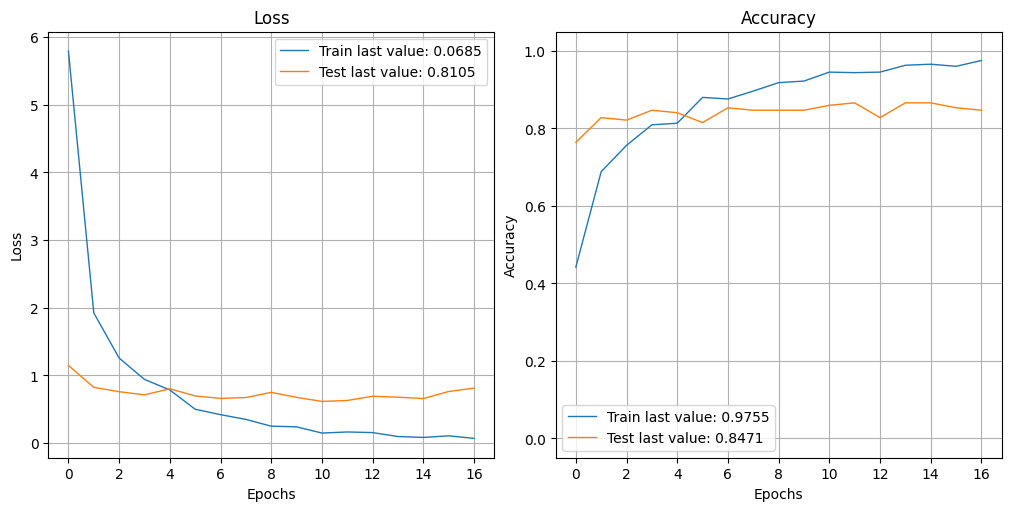

In [15]:
show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

In [16]:
#Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.8662
Test Accuracy       :  0.7848


# B) EarlyStopping (val_loss)

In [17]:
# Création du modèle
with tf.device('/gpu:0'): 
    model1 = create_model_fct()

# Création du callback
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [18]:
# Enregistrez l'heure de début
start_time = time.time()

# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'): 
    history1 = model1.fit(X_train, y_train, epochs=50, batch_size=64, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

# Enregistrez l'heure de fin
end_time = time.time()

# Calculez et affichez la durée
elapsed_time3 = end_time - start_time
print(f"Le temps d'entraînement est de: {elapsed_time3:.2f} secondes.")

Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 4.9766 - accuracy: 0.4612
Epoch 1: val_loss improved from inf to 1.14704, saving model to .\model1_best_weights.h5
12/12 [==============================] - 66s 6s/step - loss: 4.9766 - accuracy: 0.4612 - val_loss: 1.1470 - val_accuracy: 0.7834
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 1.7017 - accuracy: 0.6952
Epoch 2: val_loss improved from 1.14704 to 0.85565, saving model to .\model1_best_weights.h5
12/12 [==============================] - 65s 5s/step - loss: 1.7017 - accuracy: 0.6952 - val_loss: 0.8556 - val_accuracy: 0.8089
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 1.1349 - accuracy: 0.7660
Epoch 3: val_loss improved from 0.85565 to 0.79963, saving model to .\model1_best_weights.h5
12/12 [==============================] - 64s 5s/step - loss: 1.1349 - accuracy: 0.7660 - val_loss: 0.7996 - val_accuracy: 0.7962
Epoch 4/50
12/12 [==============================] - ETA:

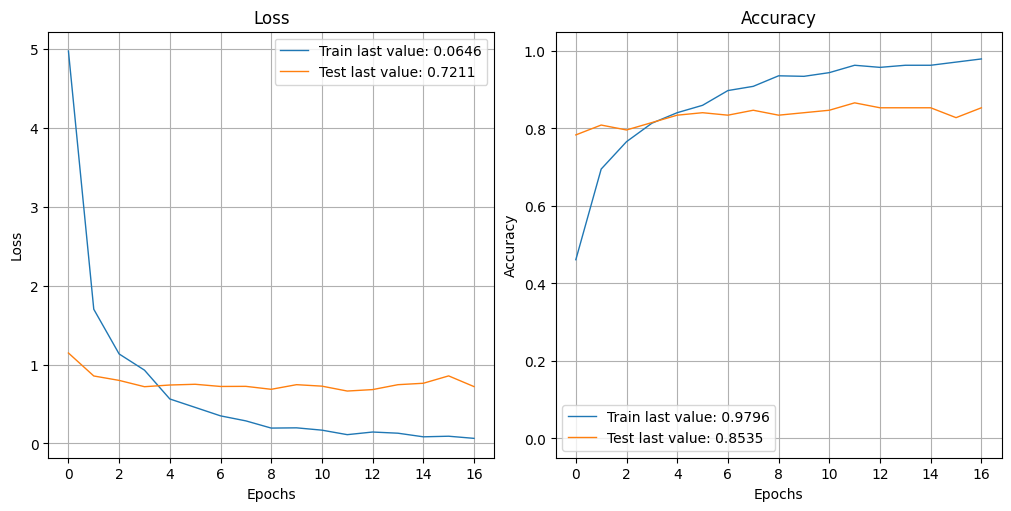

In [19]:
show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

In [20]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Loss     :  {:.4f}".format(loss))
print("Validation Accuracy :  {:.4f}".format(accuracy))

print("")

test_loss3, test_accuracy3 = model1.evaluate(X_test, y_test, verbose=False)
print("Test Loss           :  {:.4f}".format(test_loss3))
print("Test Accuracy       :  {:.4f}".format(test_accuracy3))

Validation Loss     :  0.6646
Validation Accuracy :  0.8662

Test Loss           :  1.2000
Test Accuracy       :  0.7975


# Resultat modèle 3 :

In [40]:
data3 = {
    "Modèle": ["VGG16 Transfer Learning"],
    "Nb_Epochs": [17],
    "test_loss": [test_loss3],
    "test_accuracy": [test_accuracy3],
    "temps (s)": [elapsed_time3]
}


df03 = pd.DataFrame(data3)
df03

,Modèle,Nb_Epochs,test_loss,test_accuracy,temps (s)
0,VGG16 Transfer Learning,17,1.200023,0.797468,1072.530149


# **2.6 Comparative des différents** 

In [41]:
data = {
    "Modèle": ["Perceptron multicouche", "Modèle simple CNN", "VGG16 Transfer Learning"],
    "Nb_Epochs": [20, 9, 17],
    "test_loss": [test_loss1,test_loss2,test_loss3],
    "test_accuracy": [test_accuracy1,test_accuracy2,test_accuracy3],
    "temps (s)": [elapsed_time1,elapsed_time2,elapsed_time3]
}


df1 = pd.DataFrame(data)
df1.set_index('Modèle', inplace=True)

def highlight_cells(col):
    # Dictionnaire pour mapper les colonnes aux fonctions appropriées
    mappers = {
        'Nb_Epochs': min,
        'test_loss': min,
        'test_accuracy': max,
        'temps (s)': min
    }
    
    if col.name in mappers:
        criteria = mappers[col.name](col)
        return ['background-color: green' if v == criteria else '' for v in col]
    return [''] * len(col)

styled_df = df1.style.apply(highlight_cells)
styled_df

,Nb_Epochs,test_loss,test_accuracy,temps (s)
Modèle,,,,
Perceptron multicouche,20,1396.210815,0.392405,49.074355
Modèle simple CNN,9,1.937485,0.411392,109.212760
VGG16 Transfer Learning,17,1.200023,0.797468,1072.530149


# **3. Utiliser des techniques d’augmentation des données**

# 3.1 Création de X1

In [23]:
df = pd.read_csv('C:/Users/misso/Desktop/Formation_DS_23_24_MERAH/2-Projet/6- Projet 6/Code/data_categories_image.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
print(df.shape)
df.head()

(1050, 4)


,uniq_id,image_path,label_name,label
0,55b85ea15a1536d46b7190ad6fff8ce7,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4


In [24]:
# Augmenter la limite par défaut (ici, par exemple, fixée à une valeur très élevée)
Image.MAX_IMAGE_PIXELS = None 

def image_prep_fct(df):
    # Définir le chemin d'accès relatif aux images
    base_image_path = "C:/Users/misso/Desktop/Formation_DS_23_24_MERAH/2-Projet/6- Projet 6/Ressources/Images/"

    prepared_images = []
    for image_name in df['image_path']:
        # Construire le chemin complet de l'image
        image_path = os.path.join(base_image_path, image_name)

        # Charger, traiter et prétraiter l'image
        img = load_img(image_path, target_size=(224, 224))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)

    prepared_images_np = np.array(prepared_images)
    return prepared_images_np
    
images_np = image_prep_fct(df)
X1 = images_np
print(X.shape)

(1050, 224, 224, 3)


# 3.2 Création de Y1

In [25]:
# Initialisation du LabelEncoder
label_encoder = LabelEncoder()

# Convertir les labels texte en labels numériques
y1_encoded = label_encoder.fit_transform(df['label_name'])

# Conversion des labels numériques en one-hot encoding
y1 = to_categorical(y1_encoded)

print(y.shape)

(1050, 7)


# 3.3 Séparation du jeu de données en jeu d’entraînement, jeu de validation et jeu de test

**Création de train, validation, test**

    70% pour l'entraînement
    15% pour la validation
    15% pour le test



In [26]:
X1_temp, X1_train, y1_temp, y1_train = train_test_split(X1, y1, test_size=0.7, random_state=42, stratify=y1)
X1_val, X1_test, y1_val, y1_test = train_test_split(X1_temp, y1_temp, test_size=0.5, random_state=42, stratify=y1_temp)

In [27]:
print("La forme de X1_train est :", X1_train.shape)
print("La forme de X1_val est :", X1_val.shape)
print("La forme de X1_test est :", X1_val.shape)

La forme de X1_train est : (735, 224, 224, 3)
La forme de X1_val est : (157, 224, 224, 3)
La forme de X1_test est : (157, 224, 224, 3)


# 3.4 Utilisation plusieurs techniques d’augmentation des données

**Data Augmentation: Applique différentes techniques de modification des images pour augmenter la diversité des données et aider à prévenir le surapprentissage**

  - RandomFlip: Effectue un renversement aléatoire (flip) des images horizontalement.
  - RandomRotation: Fait pivoter l'image de manière aléatoire avec un facteur maximum de 0.1 (36° max)
  - RandomZoom: Zoom aléatoire avec un facteur maximum de 0.1.

**On construit un modèle séquentiel qui comprend:**

   - La partie de data augmentation.
   - La couche Rescaling qui recale les valeurs des pixels pour qu'elles soient comprises entre -1 et 1.
   - Le modèle VGG16 pré-entraîné.
   - GlobalAveragePooling2D: Une couche de mise en commun qui convertit les caractéristiques 2D en un vecteur 1D.
   - Une couche Dense de 256 neurones avec une fonction d'activation ReLU.
   - Une couche Dropout avec un taux de 0,5 pour prévenir le surapprentissage.
   - Une autre couche Dense avec 7 neurones et une activation softmax (Pour classer les images dans 7 classes différentes)



# **3.5 Comparative des différents**

In [28]:
def create_model_fct() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
      ])
    
    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')
                ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model

In [29]:
# Création du modèle
with tf.device('/gpu:0'): 
    model1 = create_model_fct()

# Création du callback
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_2  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                      

In [30]:
# Enregistrez l'heure de début
start_time = time.time()

# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'): 
    history1 = model1.fit(X1_train, y1_train, epochs=50, batch_size=64, 
                       callbacks=callbacks_list, validation_data=(X1_val, y1_val), verbose=1)

# Enregistrez l'heure de fin
end_time = time.time()

# Calculez et affichez la durée
elapsed_time4 = end_time - start_time
print(f"Le temps d'entraînement est de: {elapsed_time4:.2f} secondes.")

Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 1.8026 - accuracy: 0.2966
Epoch 1: val_loss improved from inf to 1.36623, saving model to .\model1_best_weights.h5
12/12 [==============================] - 69s 6s/step - loss: 1.8026 - accuracy: 0.2966 - val_loss: 1.3662 - val_accuracy: 0.5287
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 1.3732 - accuracy: 0.5374
Epoch 2: val_loss improved from 1.36623 to 1.10380, saving model to .\model1_best_weights.h5
12/12 [==============================] - 62s 5s/step - loss: 1.3732 - accuracy: 0.5374 - val_loss: 1.1038 - val_accuracy: 0.6752
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 1.1709 - accuracy: 0.6395
Epoch 3: val_loss improved from 1.10380 to 0.94701, saving model to .\model1_best_weights.h5
12/12 [==============================] - 66s 6s/step - loss: 1.1709 - accuracy: 0.6395 - val_loss: 0.9470 - val_accuracy: 0.7261
Epoch 4/50
12/12 [==============================] - ETA:

12/12 [==============================] - ETA: 0s - loss: 0.4672 - accuracy: 0.8571
Epoch 28: val_loss did not improve from 0.49258
12/12 [==============================] - 52s 4s/step - loss: 0.4672 - accuracy: 0.8571 - val_loss: 0.5573 - val_accuracy: 0.8089
Epoch 29/50
12/12 [==============================] - ETA: 0s - loss: 0.4453 - accuracy: 0.8585
Epoch 29: val_loss did not improve from 0.49258
12/12 [==============================] - 54s 5s/step - loss: 0.4453 - accuracy: 0.8585 - val_loss: 0.5629 - val_accuracy: 0.8217
Epoch 30/50
12/12 [==============================] - ETA: 0s - loss: 0.4425 - accuracy: 0.8599
Epoch 30: val_loss did not improve from 0.49258
12/12 [==============================] - 57s 5s/step - loss: 0.4425 - accuracy: 0.8599 - val_loss: 0.5012 - val_accuracy: 0.8471
Epoch 31/50
12/12 [==============================] - ETA: 0s - loss: 0.4238 - accuracy: 0.8599
Epoch 31: val_loss did not improve from 0.49258
12/12 [==============================] - 64s 5s/step 

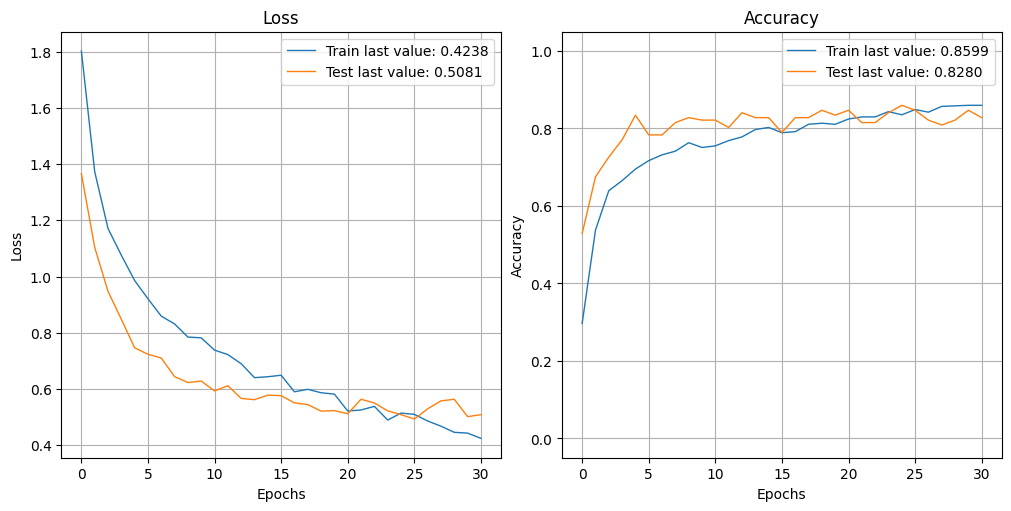

In [31]:
show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

In [32]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X1_val, y1_val, verbose=False)
print("Validation Loss     :  {:.4f}".format(loss))
print("Validation Accuracy :  {:.4f}".format(accuracy))

print("")

test_loss4, test_accuracy4 = model1.evaluate(X1_test, y1_test, verbose=False)
print("Test Loss           :  {:.4f}".format(test_loss4))
print("Test Accuracy       :  {:.4f}".format(test_accuracy4))

Validation Loss     :  0.4926
Validation Accuracy :  0.8471

Test Loss           :  0.6972
Test Accuracy       :  0.8038


In [42]:
data = {
    "Modèle": ["Perceptron multicouche", "Modèle simple CNN", "VGG16 + Transfer Learning",
               "VGG16 Transfer Learning + DATA AUGMENTATION"],
    
    "Nb_Epochs": [20,9,17,31],
    "test_loss":     [test_loss1,test_loss2,test_loss3,test_loss4],
    "test_accuracy": [test_accuracy1,test_accuracy2,test_accuracy3,test_accuracy4],
    "temps (s)":     [elapsed_time1,elapsed_time2,elapsed_time3,elapsed_time4]    
    
}

df = pd.DataFrame(data)
df.set_index('Modèle', inplace=True)

def highlight_cells(col):
    # Dictionnaire pour mapper les colonnes aux fonctions appropriées
    mappers = {
        'Nb_Epochs': min,
        'test_loss': min,
        'test_accuracy': max,
        'temps (s)': min
    }
    
    if col.name in mappers:
        criteria = mappers[col.name](col)
        return ['background-color: green' if v == criteria else '' for v in col]
    return [''] * len(col)

styled_df = df.style.apply(highlight_cells)
styled_df

,Nb_Epochs,test_loss,test_accuracy,temps (s)
Modèle,,,,
Perceptron multicouche,20,1396.210815,0.392405,49.074355
Modèle simple CNN,9,1.937485,0.411392,109.212760
VGG16 + Transfer Learning,17,1.200023,0.797468,1072.530149
VGG16 Transfer Learning + DATA AUGMENTATION,31,0.697156,0.803797,4515.723643
